In [1]:
import pandas as pd
import config as c
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from scipy import stats

In [2]:
data = pd.read_csv('data/runs/n_results.csv', index_col='run')
drug_data = pd.read_csv('data/runs/drug_data.csv')
#old_drug_data = pd.read_csv('data/runs/drug_data.csv')
#new_drug_data = pd.read_csv('data/runs/new_drug.csv')

/usr/local_rwth/sw/python/3.7.3/x86_64/extra/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data[data['status']=='completed']
data = data[data['r_2_mean'].notnull()]

In [4]:
data['time'] = pd.to_timedelta(data['time'])
data['started'] = pd.to_datetime(data['started'])

In [5]:
data['seconds'] = data['time'].apply(lambda x:x.seconds)

In [6]:
data['datasets'] = data['gdsc']+data['ctrp']+data['ccle']

In [7]:
data = data[data['datasets']>0]

In [8]:
ndata = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

In [9]:
#drug_data = pd.concat([old_drug_data, new_drug_data], sort=False)
drug_data_j = drug_data.join(ndata, rsuffix='_drug', on='run')
drug_data_j = drug_data_j[drug_data_j['started'].notnull()]

In [10]:
ndrug_data = drug_data_j[drug_data_j['started'] > pd.to_datetime('2020-04-15 18:00:00')]

In [11]:
ndata.shape

(5341, 24)

In [12]:
data[(data['datasets']>1)&(data['feda'] == True)].describe()

,time,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,727,0.0,727.0,727.000000,724.000000,0.0,727.000000,727.0,727.000000,727.000000,727.000000
mean,0 days 01:29:47.943603,NaN,4.0,20.247593,0.094952,NaN,0.010179,0.0,-0.039461,0.044682,5269.099037
std,0 days 02:10:50.689676,NaN,0.0,2.715995,0.059462,NaN,0.003651,0.0,0.046588,0.084447,6963.335236
min,0 days 00:01:02,NaN,4.0,20.000000,0.000000,NaN,0.010000,0.0,-0.275402,0.000876,62.000000
25%,0 days 00:22:08.500000,NaN,4.0,20.000000,0.041896,NaN,0.010000,0.0,-0.062199,0.008233,1328.500000
50%,0 days 00:54:40,NaN,4.0,20.000000,0.092623,NaN,0.010000,0.0,-0.014134,0.017101,3280.000000
75%,0 days 01:48:14,NaN,4.0,20.000000,0.144596,NaN,0.010000,0.0,-0.005635,0.048047,6494.000000
max,1 days 04:49:17,NaN,4.0,50.000000,0.245415,NaN,0.100000,0.0,0.000176,0.842386,63575.000000


In [13]:
#drug_data = pd.concat([drug_data, new_drug_data])
full_data = drug_data.join(data, on='run', rsuffix='_drug')

In [14]:
data.describe()

,time,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,6223,3253.000000,6224.0,6224.000000,6215.000000,0.0,6224.000000,6224.0,6224.000000,6222.000000,6223.000000
mean,0 days 00:55:19.925116,2.010144,4.0,20.297558,0.099301,NaN,0.010050,0.0,0.080004,0.338218,3181.085329
std,0 days 01:53:10.403735,0.812848,0.0,3.023049,0.057500,NaN,0.002039,0.0,1.770019,7.814914,5442.174724
min,0 days 00:00:33,1.000000,4.0,1.000000,0.000000,NaN,0.010000,0.0,-136.615707,0.000012,33.000000
25%,0 days 00:09:12.500000,1.000000,4.0,20.000000,0.049573,NaN,0.010000,0.0,-0.015811,0.091239,552.500000
50%,0 days 00:28:22,2.000000,4.0,20.000000,0.098298,NaN,0.010000,0.0,0.093292,0.130150,1702.000000
75%,0 days 01:01:03.500000,3.000000,4.0,20.000000,0.148016,NaN,0.010000,0.0,0.198688,0.201665,3663.000000
max,1 days 17:43:37,3.000000,4.0,50.000000,0.248831,NaN,0.100000,0.0,0.999979,609.875488,82747.000000


In [33]:
ndata[ndata['norm'].notnull()].sort_values('r_2_mean', ascending=False)

,operation,started,time,status,label,ccle,ctrp,cutoff,drugs,feda,...,model,n,norm,test,threshold,step,r_2_mean,r_2_std,seconds,datasets
run,,,,,,,,,,,,,,,,,,,,,
678f9d02,train:train,2020-04-20 14:38:41,02:23:17,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,RandomForestRegressor,0.141642,QuantileTransformer,NaN,0.01,0.0,0.394109,0.218128,8597.0,2
c817d1c1,train:train,2020-04-20 21:54:10,01:31:26,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,SVR,0.061395,QuantileTransformer,NaN,0.01,0.0,0.391546,0.176993,5486.0,2
399edb43,train:train,2020-04-22 03:37:12,01:32:16,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,ElasticNet,0.098535,QuantileTransformer,NaN,0.01,0.0,0.386600,0.218185,5536.0,2
b7b72d30,train:train,2020-04-22 23:20:03,01:42:36,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,KNeighborsRegressor,0.066072,MaxAbsScaler,NaN,0.01,0.0,0.380133,0.239234,6156.0,2
4b83ffb6,train:train,2020-04-21 18:15:44,00:50:20,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,ElasticNet,0.125826,QuantileTransformer,NaN,0.01,0.0,0.375033,0.200046,3020.0,2
7cce85ba,train:train,2020-04-25 00:53:30,02:57:31,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,KNeighborsRegressor,0.074267,MaxAbsScaler,NaN,0.01,0.0,0.373889,0.189286,10651.0,2
ccb9696c,train:train,2020-04-21 09:38:42,03:00:39,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,RandomForestRegressor,0.119352,QuantileTransformer,NaN,0.01,0.0,0.373249,0.136731,10839.0,2
83a3bd2b,train:train,2020-04-24 09:47:38,00:39:16,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,KNeighborsRegressor,0.011392,MinMaxScaler,NaN,0.01,0.0,0.363057,0.227744,2356.0,2
950ee138,train:train,2020-04-21 20:32:27,00:34:14,completed,ccle=no ctrp=yes cutoff=4 drugs=20 feda=no fs=...,False,True,4.0,20.0,False,...,ElasticNet,0.032061,QuantileTransformer,NaN,0.01,0.0,0.360887,0.239003,2054.0,2


## FEDA t-test

In [13]:
data[data['fs']=='Lasso'][['model', 'feda','r_2_mean']]

,model,feda,r_2_mean
run,,,
acbbf2bd,KNeighborsRegressor,True,0.026389
ddc1fcee,ElasticNet,False,0.212919
f15866de,ElasticNet,False,0.038551
9fe7654e,DecisionTreeRegressor,True,-0.183967
5e7b5693,DecisionTreeRegressor,True,-0.342574
...,...,...,...
ec5e4047,DecisionTreeRegressor,False,0.999100
81ec90e7,DecisionTreeRegressor,False,0.999535
dde14bbd,DecisionTreeRegressor,False,0.999529


In [280]:
ndata[(ndata['feda']==False)&(~ndata['model'].isin(['SVR', 'ElasticNet']))]['r_2_mean'].mean()

0.11587292792107694

In [279]:
ndata[(ndata['feda']==True)&(~ndata['model'].isin(['SVR', 'ElasticNet']))]['r_2_mean'].mean()

-0.0038146281337004995

In [16]:
stats.ttest_ind(data[data['metric']=='AUC_IC50']['r_2_mean'].values, data[data['metric']!='AUC_IC50']['r_2_mean'].values)

Ttest_indResult(statistic=-0.24245060860572498, pvalue=0.8084414212342288)

In [270]:
stats.ttest_ind(ndata[ndata['feda']==True]['r_2_mean'].values, ndata[ndata['feda']==False]['r_2_mean'].values, equal_var=False)

Ttest_indResult(statistic=-9.375550795860045, pvalue=5.019565164007916e-19)

## Model composition

In [86]:
models = data.groupby('model').mean()
models['Number of runs'] = [data[data['model']==i].shape[0] for i in models.index]
models

,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds,Number of runs
model,,,,,,,,,,,
DecisionTreeRegressor,2.013283,4.0,19.982488,0.098662,NaN,0.010000,0.0,0.057323,0.239206,1741.224885,1085
ElasticNet,2.019386,4.0,19.987622,0.097704,NaN,0.010000,0.0,0.129379,0.110828,2133.366124,1535
KNeighborsRegressor,1.993711,4.0,20.000000,0.091735,NaN,0.010000,0.0,0.137013,0.119197,8988.983158,475
RandomForestRegressor,2.082596,4.0,20.000000,0.094751,NaN,0.010000,0.0,0.238122,0.115972,3828.356044,910
SVR,1.946746,4.0,22.426187,0.113045,NaN,0.010398,0.0,0.014810,0.728735,3209.821337,779


In [87]:
ndata[ndata['norm'].notnull()].shape

(2114, 24)

In [88]:
nmodels = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')].groupby('model').mean()
nmodels['Number of runs'] = [data[(data['model']==i) & (data['started'] > pd.to_datetime('2020-04-15 18:00:00'))].shape[0] for i in nmodels.index]
nmodels

,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds,Number of runs
model,,,,,,,,,,,
DecisionTreeRegressor,2.013283,4.0,20.000000,0.098421,NaN,0.01,0.0,-0.054646,0.273964,1674.690710,915
ElasticNet,2.019386,4.0,19.983912,0.097292,NaN,0.01,0.0,0.121756,0.107183,2249.022015,1181
KNeighborsRegressor,1.993711,4.0,20.000000,0.092485,NaN,0.01,0.0,0.127679,0.121482,9206.254425,452
RandomForestRegressor,2.082596,4.0,20.000000,0.092550,NaN,0.01,0.0,0.133506,0.133647,3734.989515,763
SVR,1.946746,4.0,20.000000,0.108233,NaN,0.01,0.0,-0.026722,0.610478,3618.152542,590


In [89]:
nmodels = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')].groupby(['model', 'fs']).mean()
nmodels['Number of runs'] = [ndata[(ndata['model']==i[0]) & (ndata['fs']==i[1]) & (ndata['started'] > pd.to_datetime('2020-04-15 18:00:00'))].shape[0] for i in nmodels.index]
nmodels

ajive  cutoff      drugs  \
model                 fs                                                    
DecisionTreeRegressor ElasticNet              2.085714     4.0  20.000000   
                      Lasso                   2.033613     4.0  20.000000   
                      RandomForestRegressor   1.963636     4.0  20.000000   
                      f_regression            1.928571     4.0  20.000000   
                      mutual_info_regression  2.052632     4.0  20.000000   
ElasticNet            DecisionTreeRegressor   1.985915     4.0  20.000000   
                      Lasso                   1.992537     4.0  20.000000   
                      RandomForestRegressor   2.186441     4.0  20.000000   
                      f_regression            2.027273     4.0  19.916667   
                      mutual_info_regression  1.913043     4.0  20.000000   
KNeighborsRegressor   DecisionTreeRegressor   2.080000     4.0  20.000000   
                      ElasticNet              1.833333     4.0  20.000000   
                      Lasso                   2.086957     4.0  20.000000   
                      RandomForestRegressor   2.000000     4.0  20.000000   
                      f_regression            1.866667     4.0  20.000000   
                      mutual_info_regression  2.185185     4.0  20.000000   
RandomForestRegressor DecisionTreeRegressor   2.166667     4.0  20.000000   
                      ElasticNet              2.065789     4.0  20.000000   
                      Lasso                   2.109375     4.0  20.000000   
                      f_regression            2.000000     4.0  20.000000   
                      mutual_info_regression  2.075758     4.0  20.000000   
SVR                   DecisionTreeRegressor   2.050000     4.0  20.000000   
                      ElasticNet              2.000000     4.0  20.000000   
                      Lasso                   1.931034     4.0  20.000000   
                      RandomForestRegressor   1.851852     4.0  20.000000   
                      f_regression            2.000000     4.0  20.000000   
                      mutual_info_regression  1.826087     4.0  20.000000   

                                                     n  test  threshold  step  \
model                 fs                                                        
DecisionTreeRegressor ElasticNet              0.098599   NaN       0.01   0.0   
                      Lasso                   0.096302   NaN       0.01   0.0   
                      RandomForestRegressor   0.099631   NaN       0.01   0.0   
                      f_regression            0.097559   NaN       0.01   0.0   
                      mutual_info_regression  0.100610   NaN       0.01   0.0   
ElasticNet            DecisionTreeRegressor   0.099408   NaN       0.01   0.0   
                      Lasso                   0.093104   NaN       0.01   0.0   
                      RandomForestRegressor   0.094408   NaN       0.01   0.0   
                      f_regression            0.096903   NaN       0.01   0.0   
                      mutual_info_regression  0.103183   NaN       0.01   0.0   
KNeighborsRegressor   DecisionTreeRegressor   0.091543   NaN       0.01   0.0   
                      ElasticNet              0.095802   NaN       0.01   0.0   
                      Lasso                   0.089890   NaN       0.01   0.0   
                      RandomForestRegressor   0.082572   NaN       0.01   0.0   
                      f_regression            0.097429   NaN       0.01   0.0   
                      mutual_info_regression  0.094742   NaN       0.01   0.0   
RandomForestRegressor DecisionTreeRegressor   0.090594   NaN       0.01   0.0   
                      ElasticNet              0.090527   NaN       0.01   0.0   
                      Lasso                   0.094218   NaN       0.01   0.0   
                      f_regression            0.097999   NaN       0.01   0.0   
                      mutual_info

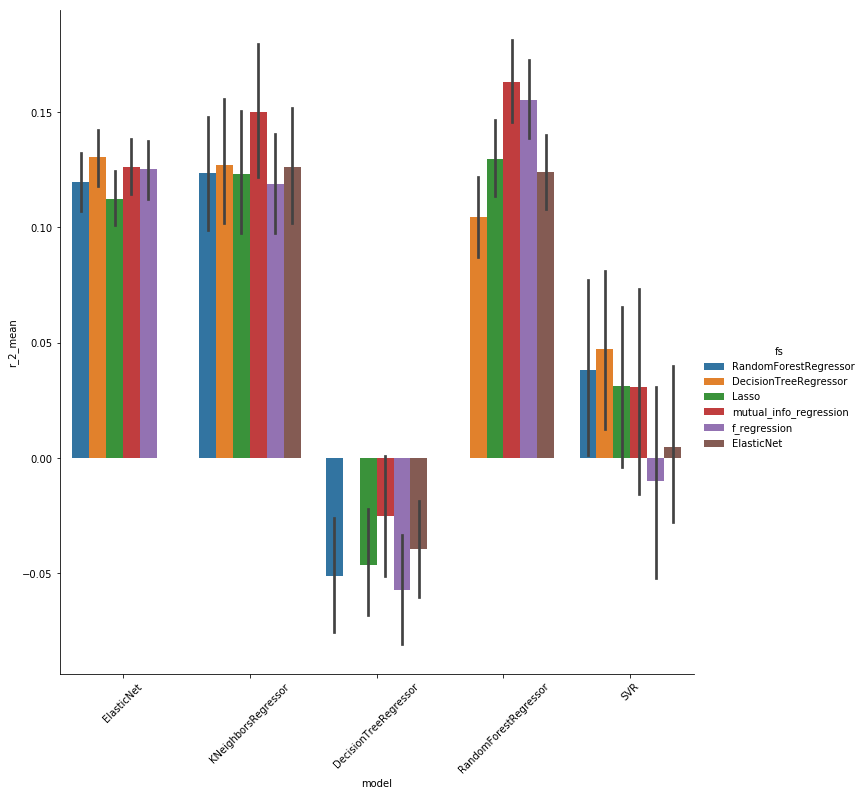

In [18]:
g = sns.catplot(x = 'model', y='r_2_mean', hue='fs', data=ndata[ndata['r_2_mean'] > -0.6], kind='bar', height=10)
g.set_xticklabels(rotation=45)

# Does normalization affect r2

In [19]:
stats.ttest_ind(ndata[ndata['norm'].isnull()]['r_2_mean'].values, ndata[ndata['norm'].notnull()]['r_2_mean'].values, equal_var=False)

Ttest_indResult(statistic=-7.097767496817448, pvalue=1.5195702808058732e-12)

In [20]:
ndata[ndata['norm'].notnull()][['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,2114.000000,2114.000000
mean,0.091472,0.191686
std,0.273554,0.936430
min,-10.539266,0.000876
25%,0.010661,0.082901
50%,0.099092,0.116788
75%,0.196806,0.170745
max,0.414408,41.080799


In [21]:
ndata[ndata['norm'].isnull()][['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,1787.000000,1786.000000
mean,0.024752,0.273792
std,0.307649,1.102404
min,-9.971771,0.001383
25%,-0.077871,0.107895
50%,0.055607,0.148040
75%,0.152273,0.225073
max,0.409924,42.588642


# Multiple datasets

In [22]:
stats.ttest_ind(ndata[ndata['datasets'] > 1]['r_2_mean'].values, ndata[ndata['datasets']==1]['r_2_mean'].values, equal_var=False)

Ttest_indResult(statistic=14.224831348411263, pvalue=6.708202557766269e-44)

In [23]:
ndata[ndata['datasets']>1][['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,2165.000000,2164.000000
mean,0.123763,0.129690
std,0.140700,0.111122
min,-0.487365,0.000876
25%,-0.005191,0.075327
50%,0.123579,0.115254
75%,0.242751,0.171182
max,0.414408,2.029289


In [24]:
ndata[ndata['datasets']==1][['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,1736.000000,1736.000000
mean,-0.017480,0.353437
std,0.394057,1.509583
min,-10.539266,0.012673
25%,-0.094834,0.111307
50%,0.051887,0.146660
75%,0.108500,0.253702
max,0.226854,42.588642


# AJIVE

In [33]:
aj = ndata[(ndata['ajive'].notnull())]
naj = ndata[(ndata['ajive'].isnull())]
stats.ttest_ind(aj['r_2_mean'].values, naj['r_2_mean'].values)

Ttest_indResult(statistic=5.867570410042254, pvalue=4.79011321190051e-09)

In [35]:
aj[['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,1813.000000,1812.000000
mean,0.090175,0.206724
std,0.174732,0.333364
min,-1.592165,0.008371
25%,0.031340,0.103582
50%,0.106427,0.134383
75%,0.205853,0.202207
max,0.414408,5.348681


In [36]:
naj[['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,2088.000000,2088.000000
mean,0.035496,0.248866
std,0.361840,1.353931
min,-10.539266,0.000876
25%,-0.042915,0.076999
50%,0.049261,0.123008
75%,0.152258,0.192712
max,0.409924,42.588642


# Domain Adaptation

In [29]:
da = ndata[(ndata['feda']==True) | (ndata['ajive'].notnull())]
notda = ndata[(ndata['feda']==False) & (ndata['ajive'].isnull())]
stats.ttest_ind(da['r_2_mean'].values, notda['r_2_mean'].values)

Ttest_indResult(statistic=-5.173664995759615, pvalue=2.410985376676931e-07)

In [31]:
da[['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,2820.000000,2819.000000
mean,0.046006,0.213127
std,0.262542,0.857483
min,-10.539266,0.000876
25%,-0.041598,0.084705
50%,0.070214,0.123598
75%,0.151083,0.191038
max,0.414408,41.080799


In [32]:
notda[['r_2_mean', 'r_2_std']].describe()

,r_2_mean,r_2_std
count,1081.000000,1081.000000
mean,0.099784,0.271427
std,0.353427,1.345106
min,-9.971771,0.012673
25%,0.045344,0.109946
50%,0.120710,0.139185
75%,0.233487,0.210230
max,0.409924,42.588642


## Per model

In [96]:
ndata[(ndata['feda']==True)&(ndata['datasets']>1)].sort_values('r_2_mean', ascending=False)

,operation,started,time,status,label,ajive,ccle,ctrp,cutoff,drugs,...,model,n,norm,test,threshold,step,r_2_mean,r_2_std,seconds,datasets
run,,,,,,,,,,,,,,,,,,,,,
e3472fd5,train:train,2020-04-20 12:25:50,01:13:36,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,ElasticNet,0.005271,QuantileTransformer,NaN,0.01,0.0,0.000176,0.005104,4416.0,3
8c025b37,train:train,2020-04-24 23:20:12,03:26:22,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,RandomForestRegressor,0.089216,NaN,NaN,0.01,0.0,0.000056,0.006732,12382.0,3
633cfe13,train:train,2020-04-25 23:11:11,00:01:48,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,ElasticNet,0.007854,StandardScaler,NaN,0.01,0.0,-0.000460,0.001989,108.0,3
4366b9f3,train:train,2020-04-22 00:48:39,02:33:58,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,ElasticNet,0.136957,MaxAbsScaler,NaN,0.01,0.0,-0.000693,0.000876,9238.0,3
15169545,train:train,2020-04-23 07:17:49,03:07:16,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,ElasticNet,0.175932,QuantileTransformer,NaN,0.01,0.0,-0.000974,0.000978,11236.0,3
5681afc6,train:train,2020-04-28 11:41:19,01:36:45,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,ElasticNet,0.105763,QuantileTransformer,NaN,0.01,0.0,-0.001094,0.002098,5805.0,3
c1d72b33,train:train,2020-04-22 00:45:46,02:20:13,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,ElasticNet,0.182000,QuantileTransformer,NaN,0.01,0.0,-0.001233,0.001605,8413.0,3
4fa000e1,train:train,2020-04-25 17:52:05,02:31:59,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,NaN,True,True,4.0,20.0,...,ElasticNet,0.140338,QuantileTransformer,NaN,0.01,0.0,-0.001342,0.001766,9119.0,3
ad3a07c8,train:train,2020-04-22 03:03:36,02:04:40,completed,ccle=yes ctrp=no cutoff=4 drugs=20 feda=yes fs...,NaN,True,False,4.0,20.0,...,ElasticNet,0.162568,QuantileTransformer,NaN,0.01,0.0,-0.001463,0.001926,7480.0,2


In [97]:
ndata.loc['51241a74']['label']

'ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes fs=Lasso gdsc=no metric=AUC_IC50 model=ElasticNet n=0.03176 threshold=0.01'

## Individual drug analysis

In [121]:
svr = data[(data['model'] == 'SVR') & (data['r_2_mean']>0)]
svr[svr['r_2_mean']> 0.6][['feda', 'n', 'fs','r_2_mean']].sort_values('r_2_mean', ascending=False)

,feda,n,fs,r_2_mean
run,,,,
c84c194d,False,0.010000,ElasticNet,0.934915
8071f94a,False,0.094795,DecisionTreeRegressor,0.922619
400d39b7,False,0.098271,DecisionTreeRegressor,0.922580
d2703cd1,False,0.147682,mutual_info_regression,0.919401
dfde6ba7,False,0.072084,mutual_info_regression,0.917935
c889fa24,False,0.087590,f_regression,0.916772
b1cea166,False,0.003354,mutual_info_regression,0.901983
e32273a7,False,0.144099,ElasticNet,0.897122
9cabe208,False,0.057282,RandomForestRegressor,0.887763


In [122]:
en = data[(data['model'] == 'ElasticNet') & (data['r_2_mean']>0)]
en[['feda', 'n', 'fs','r_2_mean']].sort_values('r_2_mean', ascending=False)

,feda,n,fs,r_2_mean
run,,,,
150587db,False,0.100081,mutual_info_regression,0.541867
140511c0,False,0.006392,DecisionTreeRegressor,0.502989
61f79f6a,False,0.146809,DecisionTreeRegressor,0.499752
a0fd39fd,False,0.161861,DecisionTreeRegressor,0.479983
d122f81c,True,0.002680,DecisionTreeRegressor,0.445192
...,...,...,...,...
ae6aad99,True,0.083612,f_regression,0.030006
30aec5a1,True,0.172041,mutual_info_regression,0.029708
c7025afd,False,0.025666,RandomForestRegressor,0.021164


In [123]:
dt = data[(data['model'] == 'DecisionTreeRegressor') & (data['r_2_mean']>0)]
dt[['feda', 'n', 'fs','r_2_mean']].sort_values('r_2_mean', ascending=False)

,feda,n,fs,r_2_mean
run,,,,
bb21f1a1,False,0.178835,Lasso,0.999979
ffb505bc,False,0.029654,Lasso,0.999978
8ee1461e,False,0.000266,Lasso,0.999976
62069de6,False,0.132054,Lasso,0.999972
43650dda,False,0.073360,Lasso,0.999966
...,...,...,...,...
25e24ad2,False,0.117603,RandomForestRegressor,0.110713
b54c0127,False,0.109115,ElasticNet,0.100940
1ea7b30d,False,0.018304,ElasticNet,0.056617


In [33]:
from config import guild
def append(data, run):
    result = pd.DataFrame()
    run = [i for i in run if i not in data['run'].values]
    print(len(run))
    for a in run:
        f = subprocess.run("guild select " +str(a), shell=True, capture_output=True)
        d = pd.read_csv(guild+'runs/'+f.stdout.decode('utf-8')[:-1]+'/scores.csv').rename(columns={'Unnamed: 0':'Drug'})
        d['run'] = [a for i in range(0, d.shape[0])]
        result = pd.concat([result, d])
        run.remove(a)
        if len(run) % 20 == 0:
            new = pd.concat([data, result])
            print('Drug data length is {}'.format(len(new)))
            print('{} runs left'.format(len(run)))
            new.to_csv('full_drug_new.csv', index=False)
    new = pd.concat([data, result])
    print('Drug data length is {}'.format(len(new)))
    new.to_csv('full_drug_new.csv', index=False)
    return new

In [37]:
new = pd.read_csv('full_drug_new.csv')

In [38]:
run = [i for i in ndata.index if i not in new['run'].values]
len(run)

30

In [39]:
k = append(new, ndata.index)

30


/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


Drug data length is 162600
20 runs left


/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Drug data length is 162687


In [87]:
drug_data = pd.read_csv('full_drug.csv').rename(columns={'Unnamed: 0': 'drug'})

In [90]:
run = [i for i in ndata.index if i not in full_data['run'].values]

In [33]:
full_data = drug_data.join(data, on='run', rsuffix='_drug')
ndata = full_data[full_data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

## Influence of n on r2 mean
By changing `col` and `hue` to 'fs' one can see the impact depending on the feature selection model use

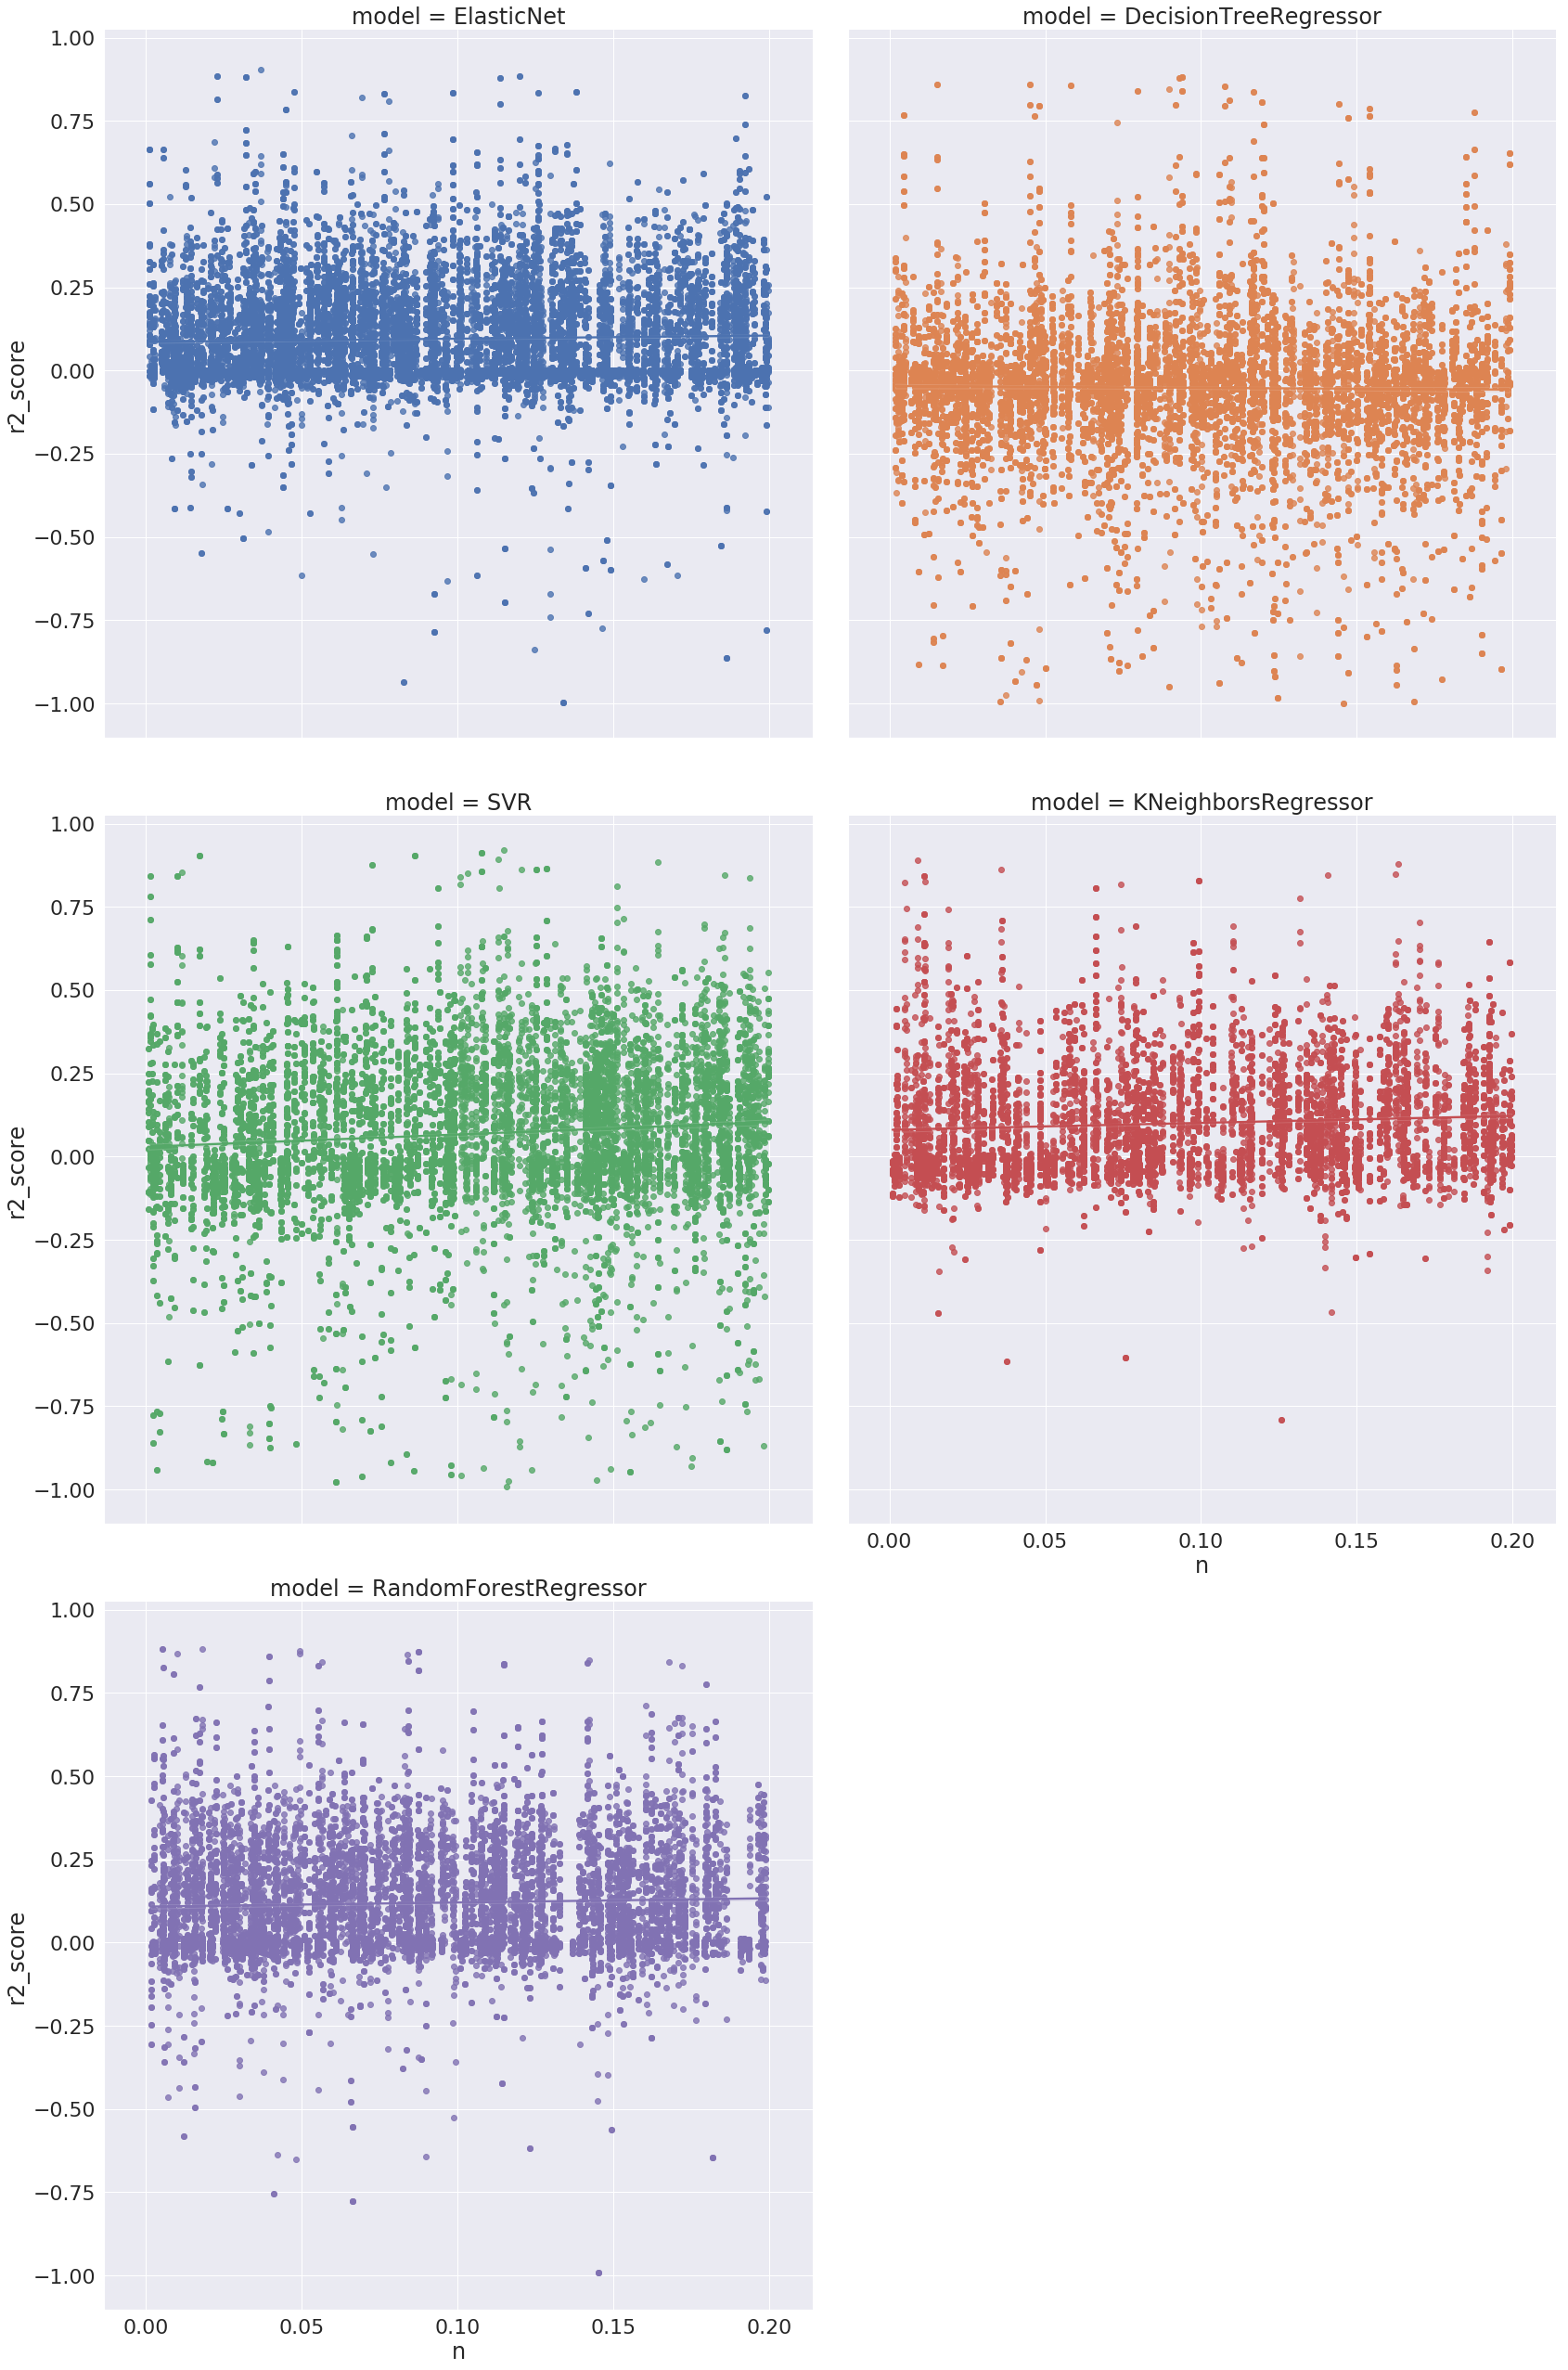

In [36]:
sns.set(font_scale=2)
g = sns.lmplot(x='n', y='r2_score', data=ndata[ndata['r2_score']>-1], col='model', hue='model', col_wrap=2, height=12, legend=False)
#plt.savefig('model vs n')

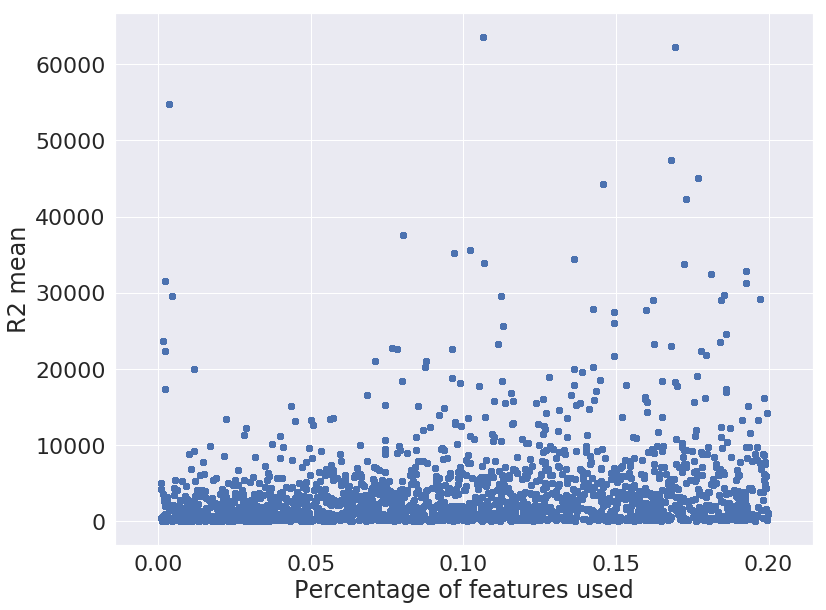

In [37]:
fig, ax = plt.subplots(figsize = (12,9))
ax.scatter(ndata[ndata['r_2_mean']>-10]['n'], ndata[ndata['r_2_mean']>-10]['seconds'])
ax.set_xlabel('Percentage of features used')
ax.set_ylabel('R2 mean')
plt.tight_layout()
#plt.savefig('Features vs r2')

## Violinplots of r2 per model and per Drug (using the top-10 most common)

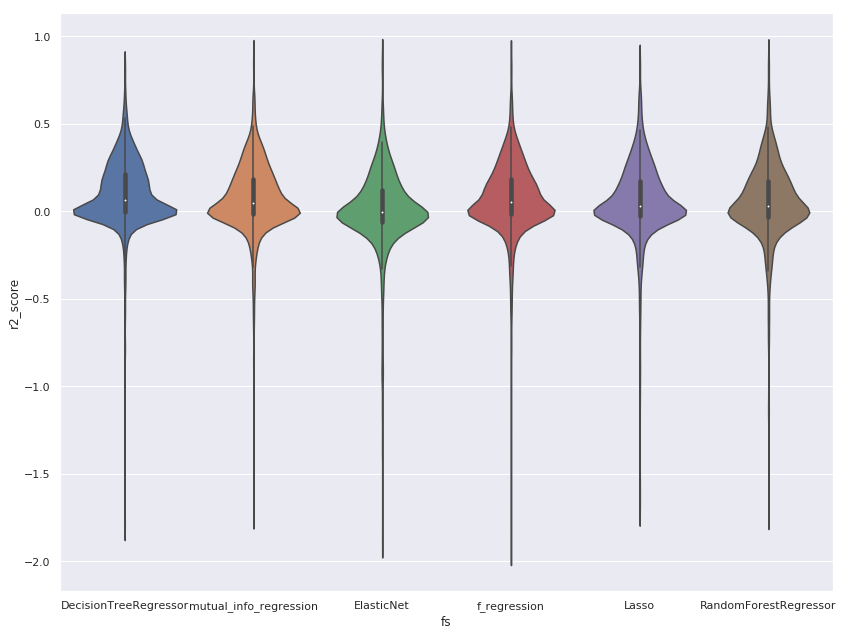

In [106]:
sns.set()
plt.figure(figsize = (12,9))
ax = sns.violinplot(x=ndrug_data[ndrug_data['r2_score']>-2]['fs'], y = ndrug_data['r2_score'])
plt.tight_layout()
#plt.savefig('model.png')

In [108]:
from collections import Counter
count = Counter(ndrug_data['Unnamed: 0'])

def getDrugs(n):
    return [i[0] for i in count.most_common(n)]

In [110]:
jo = ndrug_data[ndrug_data['Unnamed: 0'].isin(getDrugs(10))]

In [44]:
plt.figure(figsize = (12,9))
ax = sns.violinplot(x=jo['Unnamed: 0'], y = jo['r2_score'], cut=0)
ax.set_xlabel('Drug')
plt.tight_layout()
#plt.savefig('drugs.png')

NameError: name 'jo' is not defined

<Figure size 864x648 with 0 Axes>

In [187]:
lo = k.join(ndata, lsuffix='n')

In [78]:
lo.groupby('model').mean()

,r2_score,mean_absolute_error,mean_squared_error,median_absolute_error,alpha,l1_ratio,max_iter,random_state,tol,max_depth,...,epsilon,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
model,,,,,,,,,,,,,,,,,,,,,
DecisionTreeRegressor,-0.094432,0.165591,0.049621,0.138739,NaN,NaN,NaN,NaN,NaN,2.518900,...,NaN,4.0,20.0,0.090949,NaN,0.01,0.0,-0.094432,0.338541,3467.963918
ElasticNet,0.109282,0.152390,0.040928,0.135200,2.924088,0.108212,5000.0,NaN,0.0001,NaN,...,NaN,4.0,20.0,0.092379,NaN,0.01,0.0,0.109282,0.121841,2296.259854
KNeighborsRegressor,0.068197,0.152170,0.042126,0.131089,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,20.0,0.094594,NaN,0.01,0.0,0.068197,0.107072,10402.251889
RandomForestRegressor,0.108255,0.161446,0.044138,0.143393,NaN,NaN,NaN,NaN,NaN,4.345299,...,NaN,4.0,20.0,0.079032,NaN,0.01,0.0,0.108255,0.092693,4008.966154
SVR,0.015268,0.160099,0.044577,0.137407,NaN,NaN,-1.0,NaN,0.0010,NaN,...,0.1,4.0,20.0,0.067049,NaN,0.01,0.0,0.015268,0.295948,1913.851003
